In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import random

In [2]:
df = pd.read_csv('nacas.csv')
NACAS = ['4415','4412','6412','2411']
df = df.loc[(df['naca'] == '4415') | (df['naca'] == '4412') | (df['naca'] == '6412') | (df['naca'] == '2411')]

In [3]:
def Cx_data(naca, reynolds):
    return np.array(df.loc[(df['naca']==naca) & (df['reynolds'] == reynolds)]['CD'])

def Cz_data(naca, reynolds):
    return np.array(df.loc[(df['naca']==naca) & (df['reynolds'] == reynolds)]['CL'])

def Alpha_data(naca, reynolds):
    return np.array(df.loc[(df['naca']==naca) & (df['reynolds'] == reynolds)]['alpha'])

Text(0.5, 1.0, 'Cz 4412 discret')

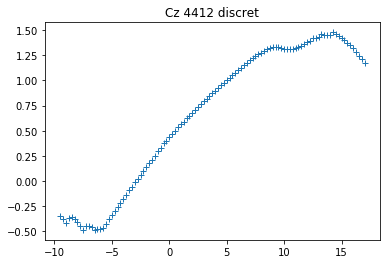

In [7]:
x = Alpha_data('4412', 100000)
y = Cz_data('4412',100000)
plt.plot(x,y,"+")
plt.title('Cz 4412 discret')

In [8]:
spl = InterpolatedUnivariateSpline(x, y, k=5)

Text(0.5, 1.0, 'Comparaison Cz 4412 interpolé / discret')

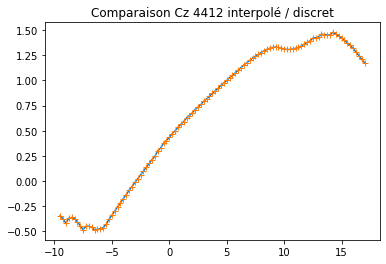

In [9]:
plt.plot(x,spl(x))
plt.plot(x,y,"+")
plt.title('Comparaison Cz 4412 interpolé / discret')

Text(0.5, 1.0, 'Comparaison Cz 4412 interpolé / discret')

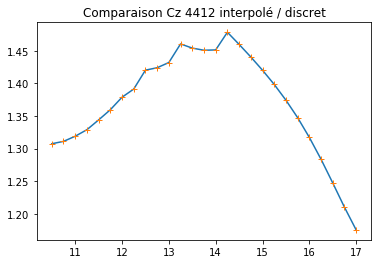

In [12]:
plt.plot(x[80:],spl(x[80:]))
plt.plot(x[80:],y[80:],"+")
plt.title('Comparaison Cz 4412 interpolé / discret')

In [13]:
def Cx_spline(naca, reynolds):
    x = Alpha_data(naca, reynolds)
    y = Cx_data(naca,reynolds)
    spl = InterpolatedUnivariateSpline(x, y, k=5)
    return spl

def Cz_spline(naca, reynolds):
    x = Alpha_data(naca, reynolds)
    y = Cz_data(naca,reynolds)
    spl = InterpolatedUnivariateSpline(x, y, k=5)
    return spl

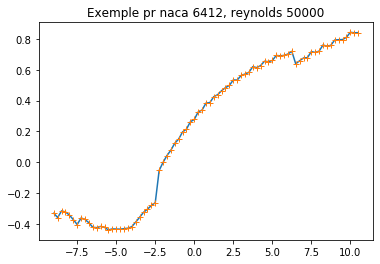

In [29]:
plt.title('Exemple pr naca 6412, reynolds 50000')
plt.plot(Alpha_data('6412',50000),Cz_spline('6412',50000)(Alpha_data('6412',50000)))
plt.plot(Alpha_data('6412',50000),Cz_data('6412',50000),"+")

In [39]:
## INUTILE :

def make_theta(delta):
    def theta(x,args):
        ind = int(x//delta)
        if 0<= x <= delta:
            return args[0]+x*args[1]
        elif x == ind*delta:
            return args[ind]*delta + theta((ind-1)*delta,args)
        else:
            return args[ind+1]*(x-ind*delta)+theta(ind*delta,args)
    return theta

def make_c(delta):
    def c(x,args):
        ind = int(x//delta)
        if 0<= x <= delta:
            return args[0]+x*args[1]
        elif x == ind*delta:
            return args[ind]*delta + c((ind-1)*delta,args)
        else:
            return args[ind+1]*(x-ind*delta)+c(ind*delta,args)
    return c

In [40]:
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import time

In [41]:
def simu(naca = '4412', N_elements = 10, r_min = 0.01, r_max = 0.07):

    # Créations des fonctions continues Cx, Cz
    func_Cx = dict()
    func_Cz = dict()
    for reynolds in [50000, 100000, 200000, 500000, 1000000]:
        func_Cx[str(reynolds)] = Cx_spline(naca, reynolds)
        func_Cz[str(reynolds)] = Cz_spline(naca, reynolds)

    # Discrétisation des rayons
    rayons = np.linspace(r_min, r_max, N_elements)

    # Calcul du pas associé
    delta = rayons[1]-rayons[0]

    n = 10000/60

    # Fonction de vitesse
    def speed(r,n):
        return 2*np.pi*r*n

    # Fonction de surface d'un trapèze
    def area(l1, l2):
        return (l1+l2)/2 * delta

    # Plus proche voisin d'un élément dans une liste

    def NN(element, L):
        l = len(L)
        cand = 0
        tol = np.abs(L[cand])+np.abs(element)
        for k in range(l):
            if np.abs(L[k]-element)<tol:
                cand = k
                tol = np.abs(L[k]-element)
        return cand

    # Fonction qui associe le Reynolds le plus proche du vrai Reynolds :

    def Reynolds(vitesse, L_c):
        mu = 1.56 * 10**-5
        all_reys = [50000,100000,500000,1000000]
        return all_reys[NN(L_c*vitesse/mu, all_reys)]

    #thetas_0 = [-15/N_elements*k+10 for k in range(N_elements)]

    #chords_0 = [0.02 for k in range(N_elements)]

    x_init = np.array([0,0,0])
    #x_init = np.zeros(2*N_elements)

    # Pour une fonction 

    def C_global(thetas, chords):
        sz = 0
        sx = 0
        div = 0
        for i in range(N_elements):
            v_i = speed(rayons[i], n)

            if i == N_elements-1:
                S_i = area(chords[i-1], chords[i])
            else:
                S_i = area(chords[i], chords[i+1])

            reynolds = Reynolds(v_i, 0.02)

            C_x = func_Cx[str(reynolds)]
            sx+= v_i**2 * S_i * C_x(thetas[i])

            C_z = func_Cz[str(reynolds)]
            sz+= v_i**2 * S_i * C_z(thetas[i])

            div+= v_i**2 * S_i

        return sz/div, sx/div
    
    def C_induit(thetas, chords, Cz):
        e = 0.8
        S_tot = 0
        for i in range(N_elements-1):
            c_i = chords[i]
            c_i2 = chords[i+1]
            S_tot+=area(c_i,c_i2)

        allongement = (r_max - r_min)**2 / S_tot

        return Cz**2/(np.pi * allongement * e)

    def puissance_trainee(args):
        thetas = fonction_vrillage(args)
        chords = fonction_corde(args)

        v_moy = np.mean(speed(rayons,n))
        pho_air = 1.3
        S_tot = 0

        Cx, Cz = C_global(thetas, chords)
        C_xi = C_induit(thetas, chords, Cz)

        for i in range(N_elements-1):
            c_i = chords[i]
            c_i2 = chords[i+1]
            S_tot+=area(c_i,c_i2)

        return 1/2 * pho_air * v_moy**3 * (C_x+C_xi) * S_tot


    def fonction_vrillage(args):
        return args[0] * rayons**2 + args[1] * rayons + args[2]
    
    def fonction_corde(args):
        return args[3] * rayons**2 + args[4] * rayons + args[5]

    def func2optim(args):
        thetas = fonction_vrillage(args)
        chords = fonction_corde(args)
        Cz, Cx = C_global(thetas, chords)
        C_xi = C_induit(thetas,chords, Cz)
        #print(Cz,Cx,C_xi)
        return -Cz / (Cx + C_xi)

    # Exécution de l'optimisation :

    t_0 = time.time()

    res = minimize(func2optim, x0 = x_init)

    print(f'Run in {int(time.time()-t_0)}')
    print(res['success'], res['nit'])
    #minimize(func2optim, x0 = thetas[0]+chords[0])
    return rayons, res

SyntaxError: invalid syntax (<ipython-input-41-2d6274d4b221>, line 92)

In [864]:
np.min(df.loc[(df['naca']=='4412')]['alpha'])

-15.75

In [865]:
rayons, res = simu()

Run in 0
True 56


In [866]:
res['x']

array([ 2.95639201e+03, -1.10293496e+02,  2.70209697e+00])

In [867]:
rayons = np.linspace(0.01, 0.07, 50)

In [868]:
def fonction_vrillage(r, args):
    return args[0]* r**2 + args[1] * r + args[2]

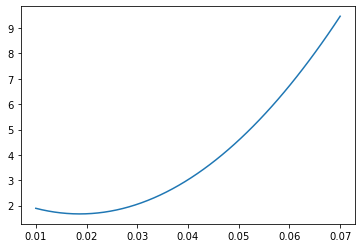

In [869]:
plt.plot(rayons,fonction_vrillage(rayons, res['x']))

In [810]:
r['x']

array([9.96379915, 9.96451893, 9.96409341, 9.96389817, 2.47086686,
       9.61549149, 9.96383537, 7.86927221, 3.97781837, 3.22913523,
       1.72248072, 4.71811563, 2.47073188, 0.72802124, 0.72752091,
       2.47075694, 0.7278343 , 2.47074251, 1.72254544, 1.72257096,
       2.47074134, 0.72784802, 0.72779507, 0.72786102, 0.72784646,
       8.48205724, 8.48216701, 8.48201922, 8.48207568, 8.4820383 ,
       8.48203541, 8.48205121, 8.4820374 , 8.4820283 , 8.48205125,
       8.48203337, 8.48205561, 8.48204705, 8.48201137, 8.48203373,
       8.48204183, 8.48204272, 8.48205361, 8.48204162, 8.48208314,
       8.48207343, 8.48199171, 8.48209446, 8.48195816, 8.48221827])

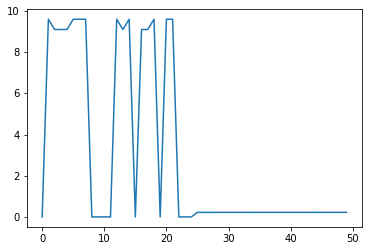

In [646]:
plt.plot(r['x'][:50])

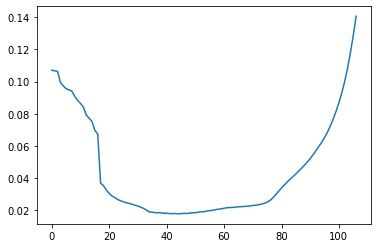

In [517]:
plt.plot(f['100000'](Alpha_data('4412',100000)))

In [499]:
np.unique(df['reynolds'])

array([  50000,  100000,  200000,  500000, 1000000], dtype=int64)